In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

Importing Data

In [2]:
df = pd.read_csv(
    'sinesp_2015_2025_consolidado.csv',
)

C:\Users\Cartesius\AppData\Local\Temp\ipykernel_22220\4009469530.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
selecao = [
    'Feminicídio',
    'Suicídio',
    'Roubo seguido de morte (latrocínio)',
    'Estupro',
    'Roubo de veículo'
]

In [4]:
def create_crime_series(
    df: pd.DataFrame,
    uf: str='RJ'
):
    """
    Transforma o DataFrame original em uma série temporal por UF,
    escolhendo entre 'total_vitima' ou 'total' dependendo do tipo de evento.
    """
    # 1. Ensure datetime index
    df['data_referencia'] = pd.to_datetime(df['data_referencia'])
    
    # 2. Filtrar pela UF solicitada
    df_filtrado = df[df['uf'] == uf].copy()
    
    # 3. Criar a representação de Mês-Ano
    df_filtrado['mes_ano'] = df_filtrado['data_referencia'].dt.to_period('M')

    # Definimos os eventos que devem usar a contagem de vítimas
    eventos_vitima = [
        "Apreensão de Cocaína", "Apreensão de Maconha", "Homicídio doloso", 
        "Feminicídio", "Estupro de vulnerável", "Estupro", 
        "Lesão corporal seguida de morte", "Roubo seguido de morte (latrocínio)", 
        "Pessoa Localizada", "Pessoa Desaparecida", 
        "Mortes a esclarecer (sem indício de crime)", 
        "Morte por intervenção de Agente do Estado", 
        "Morte no trânsito ou em decorrência dele (exceto homicídio doloso)", 
        "Morte de Agente do Estado", "Tentativa de homicídio", 
        "Suicídio de Agente do Estado", "Tentativa de feminicídio", "Suicídio"
    ]

    # Criamos uma nova coluna 'valor_final' baseada na condição
    # Se o evento está na lista, usa 'total_vitima'. Caso contrário, usa 'total'.
    df_filtrado['valor_final'] = df_filtrado.apply(
        lambda row: row['total_vitima'] if row['evento'] in eventos_vitima else row['total'], 
        axis=1
    )
    # ----------------------------------------

    # 4. Criar a tabela dinâmica usando a nova coluna 'valor_final'
    df_pivot = df_filtrado.pivot_table(
        index='mes_ano', 
        columns='evento', 
        values='valor_final', # Alterado para usar a coluna processada
        aggfunc='sum'
    ).fillna(0)
    
    # 5. Converter o índice para String
    df_pivot.index = df_pivot.index.astype(str)
    
    return df_pivot

Creating monthly time series of crimes

In [5]:
series = {
    uf:create_crime_series(
        df=df,
        uf=uf
    )

    for uf in df['uf'].unique()
}

Defining metric functions for evaluating forecasts

In [6]:
eval_functions = {
    # Mean Absolute Error
    'MAE': mean_absolute_error,
    # Root Mean Squared Error
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    # Mean Absolute Percentage Error
    'MAPE': lambda y_true, y_pred: np.mean(np.abs(y_true - y_pred) / y_true) * 100,
    # Direction
    'Direction': lambda y_true, y_pred: np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))
}

Generating rolling one-step-ahead forecasts

In [7]:
# Defining dictionary for storing error metrics and series
results = {
    metric:{}
    for metric in ['RMSE','MAE','MAPE','Direction','Series']
}

# List of state names (UFs)
lista_ufs = list(series.keys())

# Date of start of the test set
start_test = '2022-01'

# Type of crime
crime = 'Homicídio doloso'

# Iterating over each state
for uf in tqdm(lista_ufs):
    
    # Selecting monthly time series of crime counts for the given state
    serie_atual = series[uf][crime].copy()

    # Ensuring datetime index
    serie_atual.index = pd.to_datetime(serie_atual.index)
    
    datas_teste = serie_atual[start_test:].index
    
    preds_hw = []
    preds_naive = []
    reais = []
    anteriores = []

    # Iterating over each day of the test set
    for data in datas_teste:

        # Updating train set until the most recent observation (rolling model)
        treino = serie_atual[:data - pd.DateOffset(months=1)]
        if len(treino) < 24:
            continue
            
        real = serie_atual[data]
        ultimo_valor_treino = treino.iloc[-1]
        
        # Tries to fit Holt Winters model to the data
        try:

            # Model specification and fitting
            modelo_hw = ExponentialSmoothing(
                treino,
                trend='add',
                seasonal='add',
                seasonal_periods=12
            ).fit()

            # Generating one-step-ahead forecast
            previsao_hw = modelo_hw.forecast(1)[0]

        # If not possible, returns np.nan as forecast
        except:
            previsao_hw = np.nan
            
        preds_hw.append(previsao_hw)
        preds_naive.append(ultimo_valor_treino)
        reais.append(real)
        anteriores.append(ultimo_valor_treino)

    # --- SALVANDO AS SÉRIES PREDITAS ---
    # Criamos um DataFrame com as datas reais como índice
    df_preds = pd.DataFrame({
        'Real': reais,
        'Holt-Winters': preds_hw,
        'Naive': preds_naive
    }, index=datas_teste[:len(reais)]) # Garante alinhamento com as datas
    
    results['Series'][uf] = df_preds

    # Calculating metrics
    reais_np = np.array(reais)
    preds_hw_np = np.array(preds_hw)
    preds_nv_np = np.array(preds_naive)
    ant_np = np.array(anteriores)

    # Iterating over each evaluation metric
    for metric in eval_functions:

        # Calculating metric for HW and naive benchmark forecasts
        results[metric][uf] = {
            'Holt-Winters': eval_functions[metric](reais_np, preds_hw_np),
            'Naive Benchmark': eval_functions[metric](reais_np, preds_nv_np)
        }

# Creating dataframes with metrics
dfs = {a:pd.DataFrame(results[a]).T for a in eval_functions}

  0%|          | 0/27 [00:00<?, ?it/s]c:\Users\Cartesius\Desktop\Projetos\Crimes\CrimesEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cartesius\AppData\Local\Temp\ipykernel_22220\841507313.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  previsao_hw = modelo_hw.forecast(1)[0]
c:\Users\Cartesius\Desktop\Projetos\Crimes\CrimesEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cartesius\AppData\Local\Temp\ipykernel_22220\841507313.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In 

In [8]:
dfs['MAPE']['Naive Benchmark'] - dfs['MAPE']['Holt-Winters']

AC     5.343157
AL     3.302755
AM     0.402511
AP    -2.097768
BA     1.253366
CE     1.141067
DF     0.631446
ES    -0.773029
GO    -1.441151
MA     2.142468
MG    -0.095091
MS     2.862833
MT    -3.458060
PA    -2.073301
PB     0.071960
PE     0.969722
PI     2.253345
PR    -0.226326
RJ     1.300089
RN     4.183094
RO     1.144311
RR   -25.206153
RS     2.219140
SC     7.826515
SE     7.148237
SP          NaN
TO     1.581158
dtype: float64

In [9]:
px.violin(
    dfs['MAPE']['Naive Benchmark'] - dfs['MAPE']['Holt-Winters'],
    orientation='h',
    points='all',
    box=True
)

In [15]:
dfs.keys()

dict_keys(['MAE', 'RMSE', 'MAPE', 'Direction'])

In [17]:
dfs['Direction']['Holt-Winters']

AC    0.422222
AL    0.377778
AM    0.555556
AP    0.288889
BA    0.622222
CE    0.400000
DF    0.600000
ES    0.422222
GO    0.622222
MA    0.422222
MG    0.644444
MS    0.444444
MT    0.444444
PA    0.533333
PB    0.422222
PE    0.511111
PI    0.444444
PR    0.444444
RJ    0.545455
RN    0.533333
RO    0.333333
RR    0.555556
RS    0.533333
SC    0.488889
SE    0.488889
SP    0.577778
TO    0.555556
Name: Holt-Winters, dtype: float64

In [10]:
dfs['MAPE']

,Holt-Winters,Naive Benchmark
AC,28.599526,33.942683
AL,12.549533,15.852288
AM,13.427287,13.829798
AP,41.303976,39.206208
BA,7.770909,9.024275
CE,8.726032,9.867099
DF,26.167881,26.799327
ES,18.460756,17.687728
GO,19.308381,17.867230
MA,9.593561,11.736029


Forecasting plot

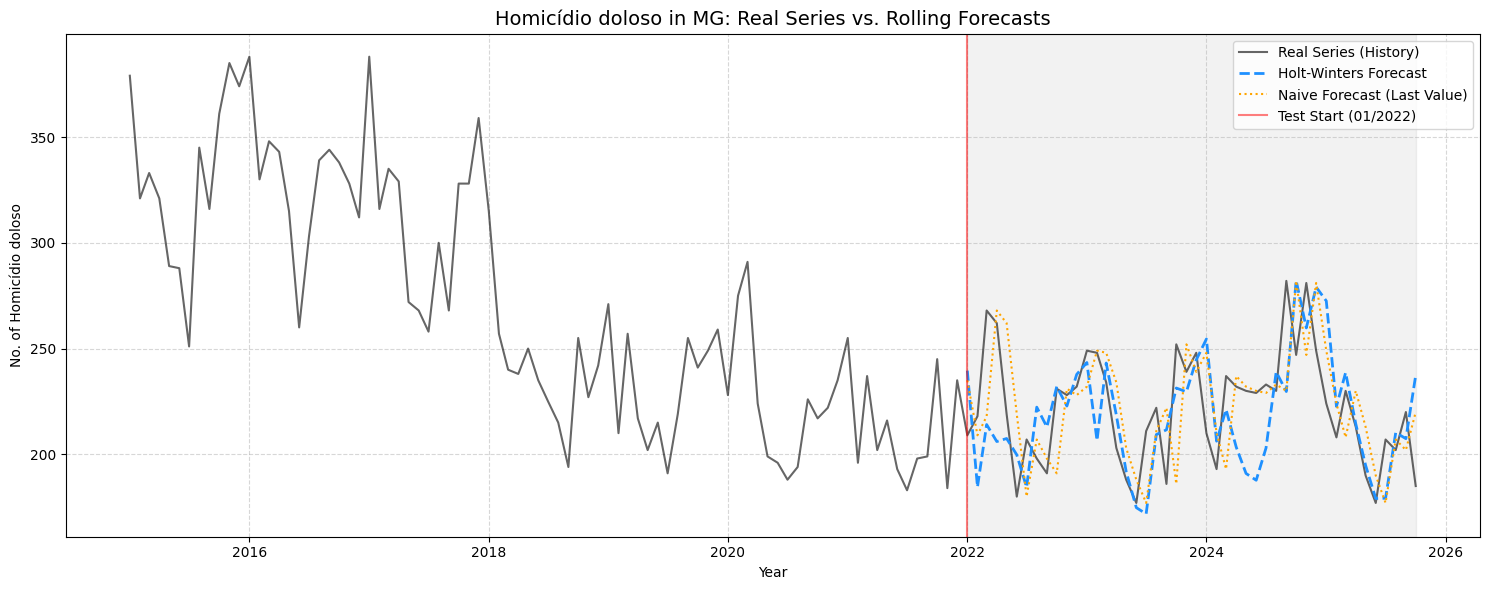

In [13]:
def plot_forecasts(series_original, resultados_series, uf, evento='Homicídio doloso'):
    """
    Generates a comparative plot between the real history and forecasts for a specific State (UF).
    """
    # 1. Data extraction
    # Get the original historical series for the plot background
    serie_historica = series_original[uf][evento].copy()
    serie_historica.index = pd.to_datetime(serie_historica.index)
    
    # Get the previously generated forecasts DataFrame
    df_preds = resultados_series[uf]
    df_preds.index = pd.to_datetime(df_preds.index)
    
    start_test = df_preds.index[0]
    end_test = df_preds.index[-1]

    # 2. Plot Configuration
    plt.figure(figsize=(15, 6))

    # Plot the full real series (History + Test Period)
    plt.plot(serie_historica.index, serie_historica.values, 
             label='Real Series (History)', color='black', linewidth=1.5, alpha=0.6)

    # Plot forecasts (Holt-Winters and Naive)
    plt.plot(df_preds.index, df_preds['Holt-Winters'], 
             label='Holt-Winters Forecast', color='dodgerblue', linestyle='--', linewidth=2)
    
    plt.plot(df_preds.index, df_preds['Naive'], 
             label='Naive Forecast (Last Value)', color='orange', linestyle=':', linewidth=1.5)

    # 3. Styling and Demarcation
    # Vertical line separating training from testing
    plt.axvline(start_test, color='red', linestyle='-', alpha=0.5, label=f'Test Start ({start_test.strftime("%m/%Y")})')

    # Fill the test area for visual emphasis
    plt.axvspan(start_test, end_test, color='gray', alpha=0.1)

    # Titles and labels
    plt.title(f'{evento} in {uf}: Real Series vs. Rolling Forecasts', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel(f'No. of {evento}')
    plt.legend(loc='upper right')
    plt.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_forecasts(series, results['Series'], 'MG')